# Libraries

In [3]:
import os

import torch
import torch.nn as nn 
import torch.nn.functional as F 

from torch.utils.data import Dataset
from torch.utils.data import DataLoader 

from torchvision import datasets, transforms
from torchvision.io import read_image
import torchvision.utils as vutils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from PIL import Image 
import imageio
from einops import rearrange 
from tqdm import tqdm 

import wandb

%matplotlib inline

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("torch version:", torch.__version__)


CUDA available: False
torch version: 2.6.0


# CVAE Model

### Creating the CVAE model.


In [5]:
#######################################################
# CVAE IMPLEMENTATION 
#######################################################

class CVAE(nn.Module): 
    def __init__(self, input_dim=38_804, h1_dim=1024, h2_dim=512, h3_dim=256, latent_dim=100): 
        super().__init__()

        # Encoder Layers 
        self.fc1 = nn.Linear(input_dim, h1_dim)
        self.fc2 = nn.Linear(h1_dim, h2_dim)
        self.fc3 = nn.Linear(h2_dim, h3_dim)
        self.fc41 = nn.Linear(h3_dim, latent_dim)  # mu 
        self.fc42 = nn.Linear(h3_dim, latent_dim)  # log var 

        # Decoder Layers 
        self.fc5 = nn.Linear(latent_dim, h1_dim)
        self.fc6 = nn.Linear(h1_dim, h2_dim)
        self.fc7 = nn.Linear(h2_dim, input_dim)
    
    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        The encoder portion of the CVAE. 

        Args: 
            x (Tensor): Input data of shape [batch_size, 178 x 218], flattened images.

        Returns:
            Tuple[Tensor, Tensor]: The mean and log-variance of the approximate posterior 
            distribution q(z|x), where z is the latent variable. 
        '''

        h1 = F.relu(self.fc1(x)) 
        h2 = self.fc2(h1)
        h3 = F.relu(self.fc3(h2))
        mu = self.fc41(h3)
        logvar = self.fc42(h3) 
        
        return mu, logvar

    def reparametrize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        '''
        Reparametrization trick standard in CVAE's. 

        Args: 
            mu: The mean of the approximate posterior distribution: q(z|x)
            logvar: The log-variance of the approximate posterior distribution: q(z|x)
        
        Returns: 
            z: The latent variable sampled from q(z|x) using the reparametrization trick.
            z is size [batch_size, latent_dim], in this case, latent_dim=100.
        ''' 
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        z = mu + std * eps 
        return z 

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        '''
        The decoder portion of CVAE. 

        Args: 
            z: The latent variable. 

        Returns: 
            x_recon: The reconstructed x sampled from the learned distribution of the decoder. 
            In this case, x_recon is a reconstructred picture. 
        '''
        h1 = F.relu(self.fc5(z))
        h2 = F.relu(self.fc6(h1))
        x_recon = F.sigmoid(self.fc7(h2))

        return x_recon
    
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]: 
        """
        The forward pass on the CVAE. 
        """

        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_recon = self.decode(z)
        
        return x_recon, mu, logvar

In [6]:
"""
CVAE TESTING CELL 
"""
 
test_x = torch.rand([1, 178 * 218])   # Test "picture"
#print(test_x)
#print("Shape:", test_x.size())

# Test the forward pass.
cvae = CVAE() 
x_recon, mu, logvar = cvae.forward(test_x)
#print("Reconstructed x:", x_recon)
#print("Shape of x_recon:", x_recon.size())



# Dataset Class

### Create a custom dataset class compatible with the torch.DataLoader class
### https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

The custom dataset class needs 3 functions: `__init__`, `__len__`, and `__getitem__`. 

Use an image directory, in my case "data/CelebA/img_align_celeba/. 

Use an annotations file, which is the metadata for the image, or the relevant features for the model to know. 

Notes: 
    - transforms perform manipulation on data to make it suitable for machine learning models to train on.

In [7]:
class CelebAImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        '''
        Args:
            annotations_file: The dataset containing all of the relevant labels. 
            landmarks_file: Specific to the CelebA dataset, used as additional labels.
            img_dir: The path to the images folder. 
            transform: Modifies the feature data.
            target_transform: Modifies the label data.   
        '''
        self.img_labels = pd.read_csv(annotations_file)
        #self.img_landmarks = pd.read_csv(landmarks_file) for simplicity, i wont use this yet.
        self.img_dir = img_dir 
        self.transform = transform 
        self.target_transform = target_transform 
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx): 
        '''
        Retrieves the image and its labels of the corresponding index. 
        '''
        # img_dir in this case is ../data/CelebA/img_align_celeba/img_align_celeba
        # ie. ../data/CelebA/img_align_celeba/img_align_celeba/000001.jpg
        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) 
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1:] # retrieves the vector of labels
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)

        return image, labels

        


In [ ]:
annotations_file = "../data/CelebA/list_attr_celeba.csv"
img_dir = "../data/CelebA/img_align_celeba/img_align_celeba"

celeba = CelebAImageDataset(annotations_file, img_dir=img_dir)
image, labels = celeba.__getitem__(0)

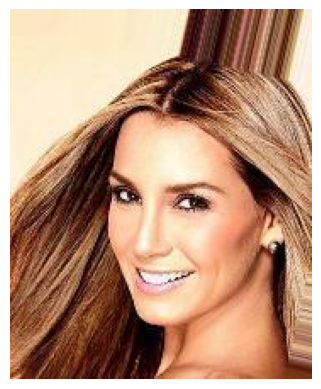

In [12]:
image_np = image.permute(1, 2, 0).numpy()

plt.imshow(image_np)
plt.axis("off")
plt.show()